In [161]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from calendar import monthrange
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [118]:
# Load the raw solar dataset from CSV
raw_data = pd.read_csv("india_monthly_full_release_long_format.csv")
print("Raw Data Preview")
raw_data.head()

Raw Data Preview


,State,Date,Capacity - Bioenergy (MW),Capacity - Clean (MW),Capacity - Coal (MW),Capacity - Fossil (MW),Capacity - Gas (MW),Capacity - Gas and Other Fossil (MW),Capacity - Hydro (MW),"Capacity - Hydro, Bioenergy and Other Renewables (MW)",...,Electricity generation - Other Renewables (GWh),Electricity generation - Renewables (%),Electricity generation - Renewables (GWh),Electricity generation - Solar (%),Electricity generation - Solar (GWh),Electricity generation - Total Generation (GWh),Electricity generation - Wind (%),Electricity generation - Wind (GWh),Electricity generation - Wind and Solar (%),Electricity generation - Wind and Solar (GWh)
0,Andaman and Nicobar,1/1/2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,27.11,2.56,15.25,1.44,9.44,0.0,0.0,15.25,1.44
1,Andaman and Nicobar,2/1/2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,28.08,2.71,17.82,1.72,9.65,0.0,0.0,17.82,1.72
2,Andaman and Nicobar,3/1/2019,0.0,16.98,0.0,40.05,0.0,40.05,5.25,5.25,...,0.0,31.05,3.12,20.40,2.05,10.05,0.0,0.0,20.40,2.05
3,Andaman and Nicobar,4/1/2019,0.0,16.98,0.0,40.05,0.0,40.05,5.25,5.25,...,0.0,22.75,2.57,17.17,1.94,11.30,0.0,0.0,17.17,1.94
4,Andaman and Nicobar,5/1/2019,0.0,16.98,0.0,40.05,0.0,40.05,5.25,5.25,...,0.0,17.72,1.78,16.43,1.65,10.04,0.0,0.0,16.43,1.65


In [119]:
# Add Month, Year, and Hours in Month
def add_date_parts(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data['Month'] = data['Date'].dt.month   
    data['Year'] = data['Date'].dt.year
    data['YearMonth'] = pd.to_datetime(data['Date'].dt.to_period('M').astype(str))
    data['Hours in Month'] = data['Date'].dt.daysinmonth * 24   
    return data

raw_data = add_date_parts(raw_data)

In [120]:
def rename_columns(data):
    return data.rename(columns={
        'Capacity - Solar (MW)': 'Solar Capacity (MW)',
        'Electricity generation - Solar (GWh)': 'Solar Generation (GWh)',
        'Electricity generation - Solar (%)': 'Solar Share (%)',
        'Electricity generation - Total Generation (GWh)': 'Total Generation (GWh)'
    })

raw_data = rename_columns(raw_data)

In [121]:
raw_data['Solar Capacity (GWh)'] = raw_data['Solar Capacity (MW)'] * raw_data['Hours in Month'] / 1000

In [122]:
# Remove unreliable states
remove_states = ['India Total', 'Ladakh', 'Jammu and Kashmir', 'Meghalaya', 'Nagaland', 'Sikkim', 'Others']
raw_data = raw_data[~raw_data['State'].isin(remove_states)]

# Final selected columns
clean_data = raw_data[[
    'State', 'YearMonth', 'Month', 'Year',
    'Solar Capacity (GWh)', 'Solar Generation (GWh)',
    'Solar Share (%)', 'Total Generation (GWh)'
]]

In [123]:
clean_data = clean_data.dropna()

In [124]:
clean_data.to_csv("cleaned_solar_data.csv", index=False)

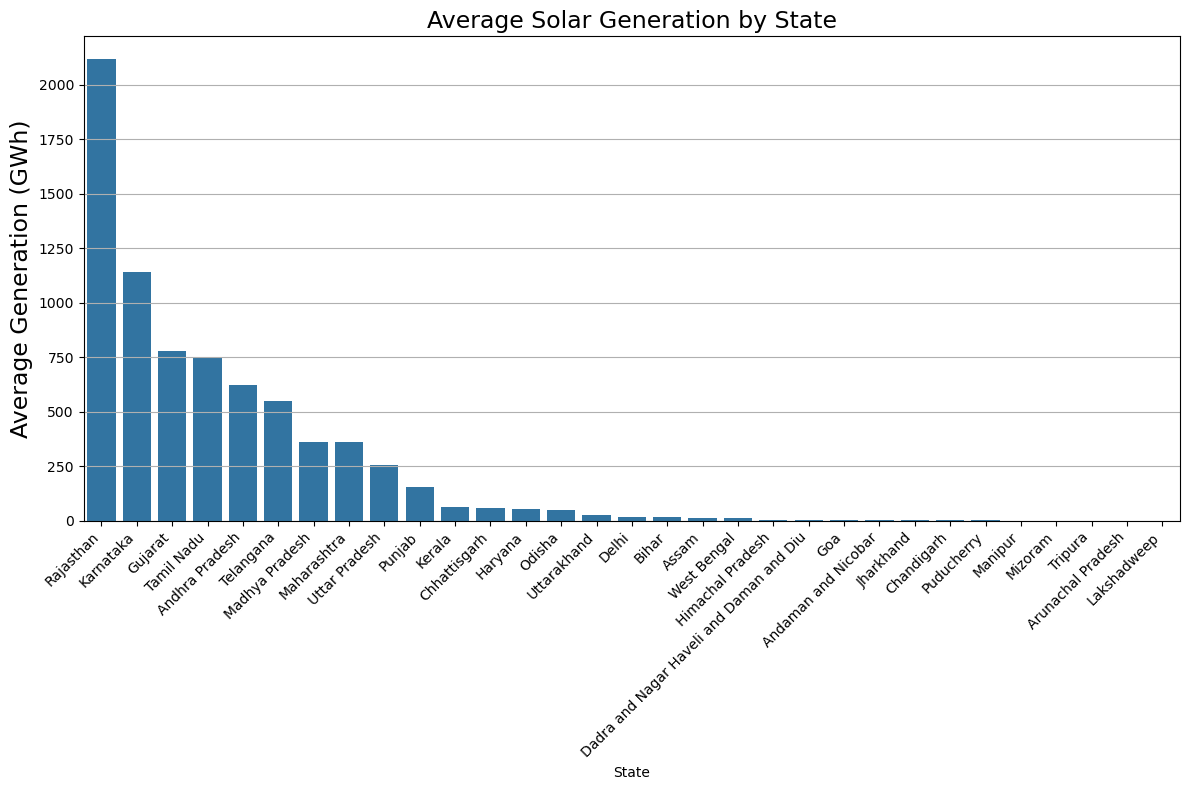

In [125]:
def plot_total_generation_by_state(data):
    total_gen = data.groupby('State')['Solar Generation (GWh)'].mean().sort_values(ascending=False).reset_index()
    plt.figure(figsize=(12, 8))
    sns.barplot(x='State', y='Solar Generation (GWh)', data=total_gen)
    plt.title("Average Solar Generation by State", fontsize=17)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.ylabel("Average Generation (GWh)", fontsize=17)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

plot_total_generation_by_state(clean_data)

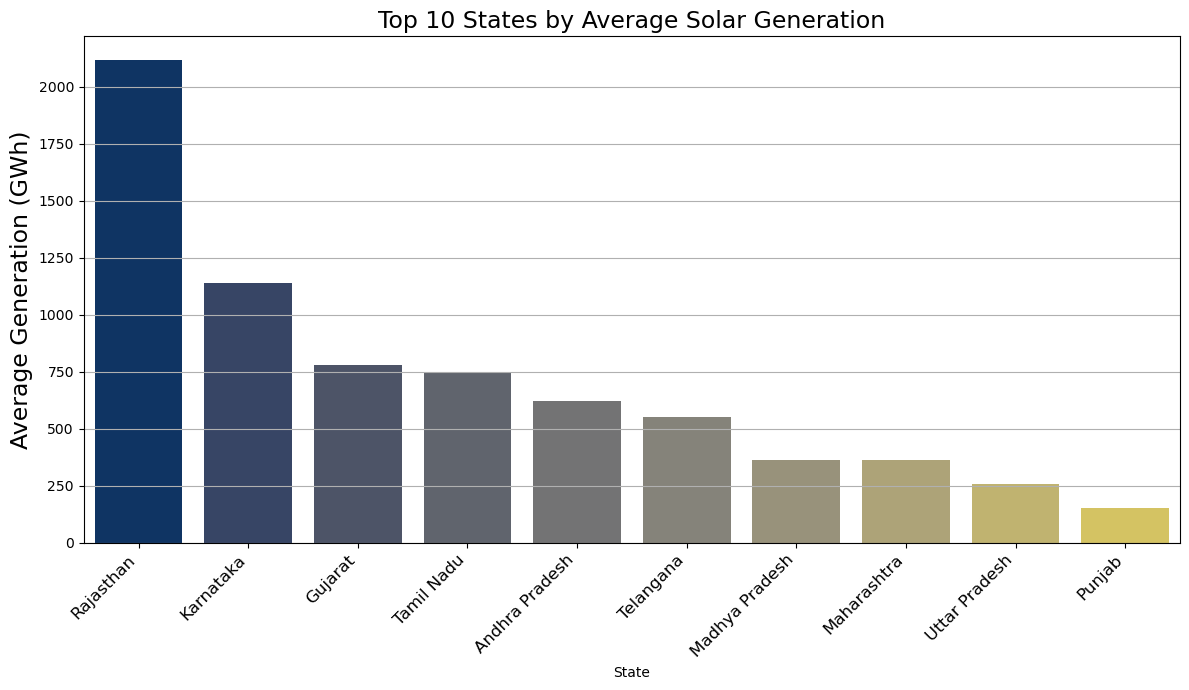

In [126]:
def plot_avg_generation_top_10(data):
    avg_gen = data.groupby('State')['Solar Generation (GWh)'].mean().sort_values(ascending=False).head(10).reset_index()
    plt.figure(figsize=(12, 7))
    sns.barplot(x='State', y='Solar Generation (GWh)', data=avg_gen, hue='State', palette='cividis')
    plt.title("Top 10 States by Average Solar Generation", fontsize=17)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.ylabel("Average Generation (GWh)", fontsize=17)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

plot_avg_generation_top_10(clean_data)

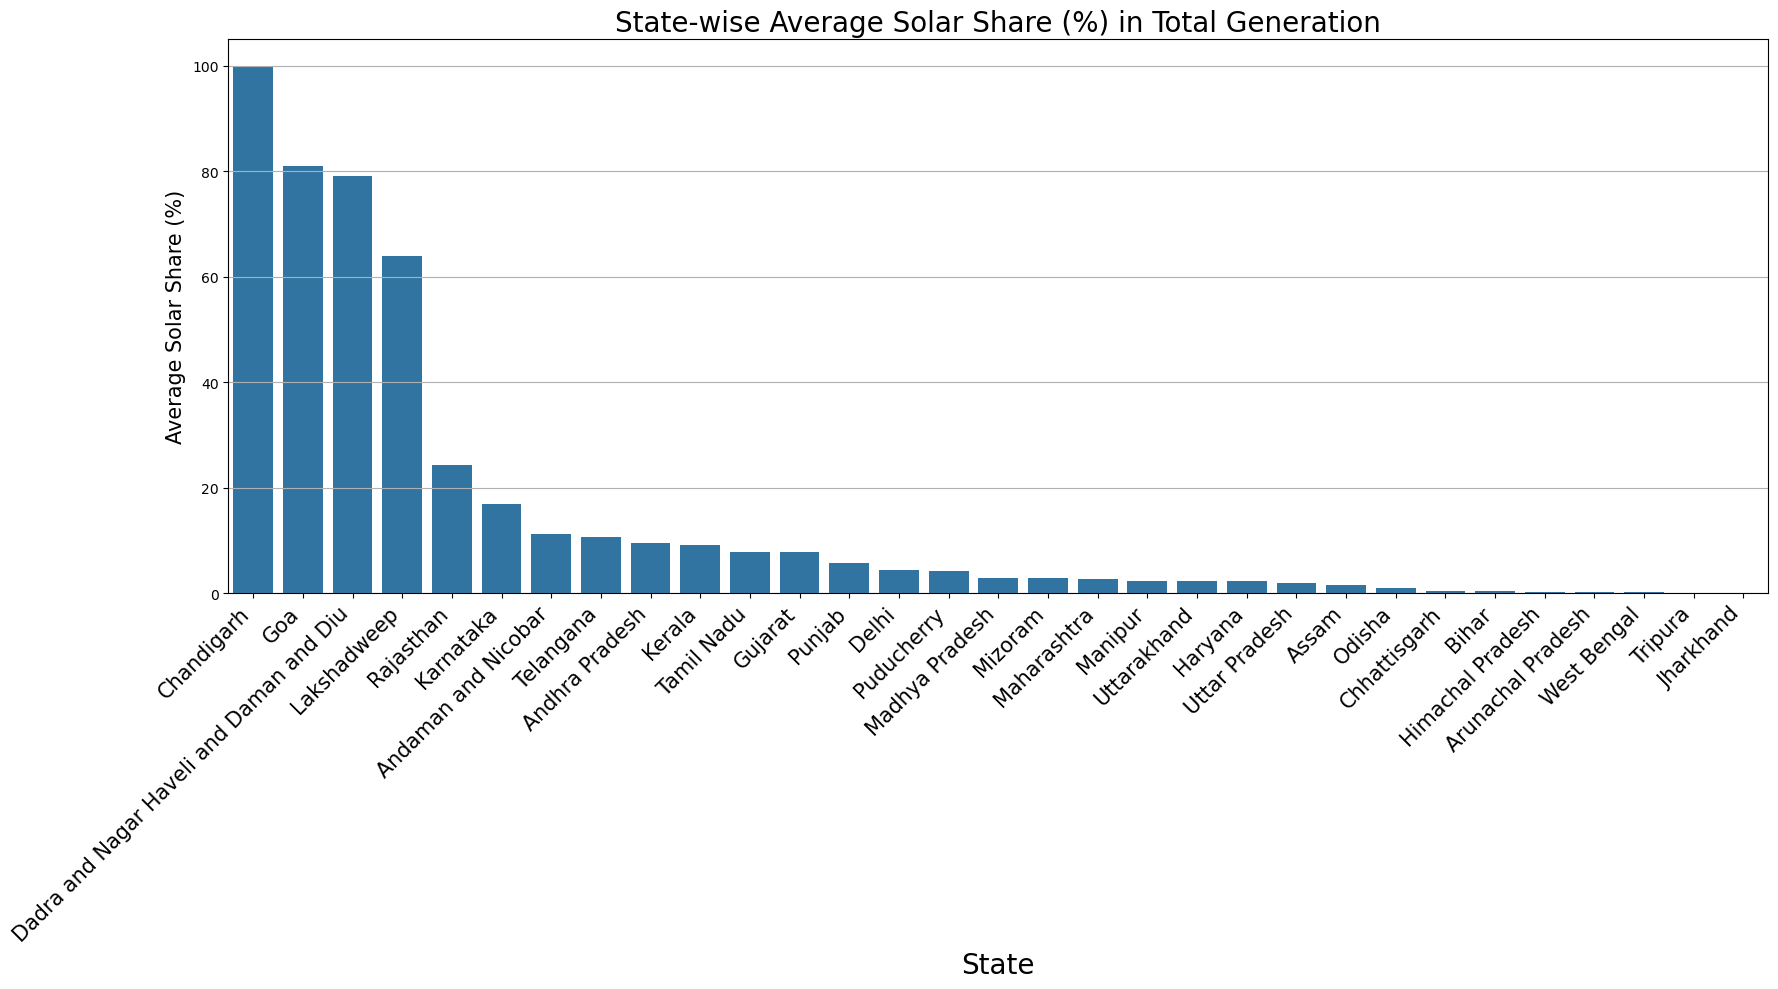

In [127]:
def plot_statewise_solar_share(data):
    state_avg = data.groupby("State")["Solar Share (%)"].mean().sort_values(ascending=False).reset_index()
    plt.figure(figsize=(18, 10))
    sns.barplot(x='State', y='Solar Share (%)', data=state_avg)
    plt.title("State-wise Average Solar Share (%) in Total Generation", fontsize=20)
    plt.xlabel("State", fontsize=20)
    plt.ylabel("Average Solar Share (%)", fontsize=15)
    plt.xticks(rotation=45, ha='right', fontsize=15)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

plot_statewise_solar_share(clean_data)

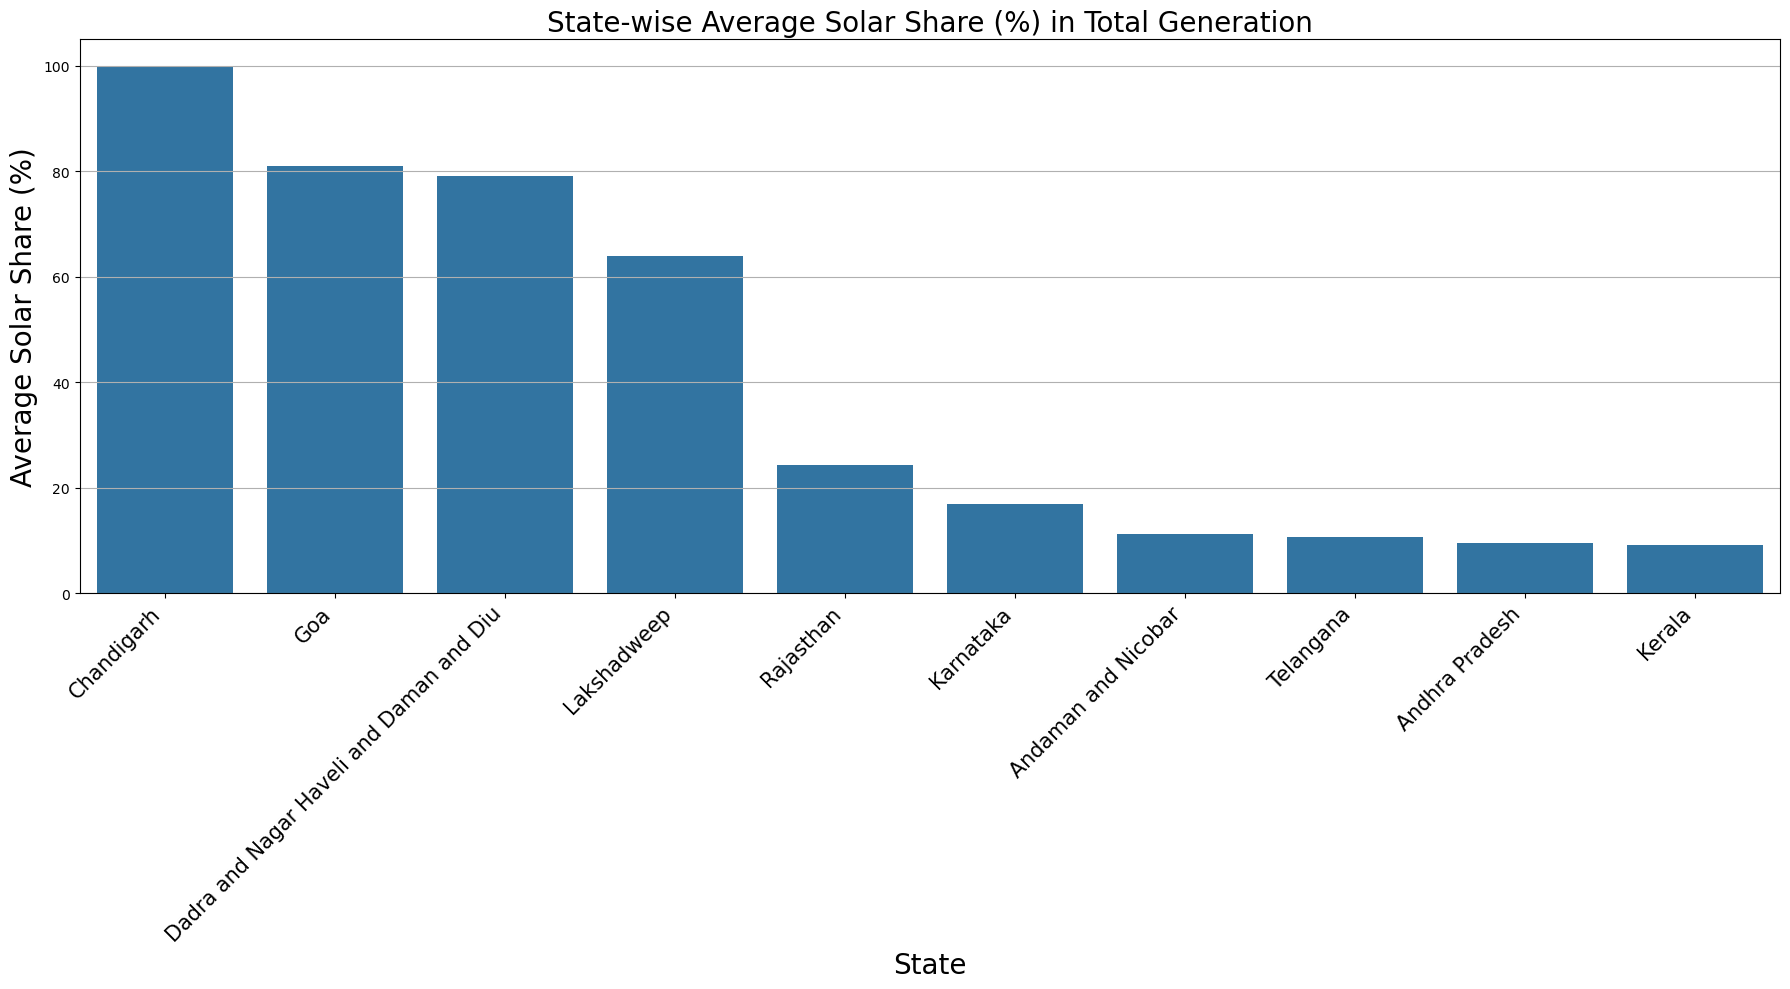

In [128]:
def plot_statewise_solar_share(data):
    state_avg = data.groupby("State")["Solar Share (%)"].mean().sort_values(ascending=False).head(10).reset_index()
    plt.figure(figsize=(18, 10))
    sns.barplot(x='State', y='Solar Share (%)', data=state_avg)
    plt.title("State-wise Average Solar Share (%) in Total Generation", fontsize=20)
    plt.xlabel("State", fontsize=20)
    plt.ylabel("Average Solar Share (%)", fontsize=20)
    plt.xticks(rotation=45, ha='right', fontsize=15)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

plot_statewise_solar_share(clean_data)

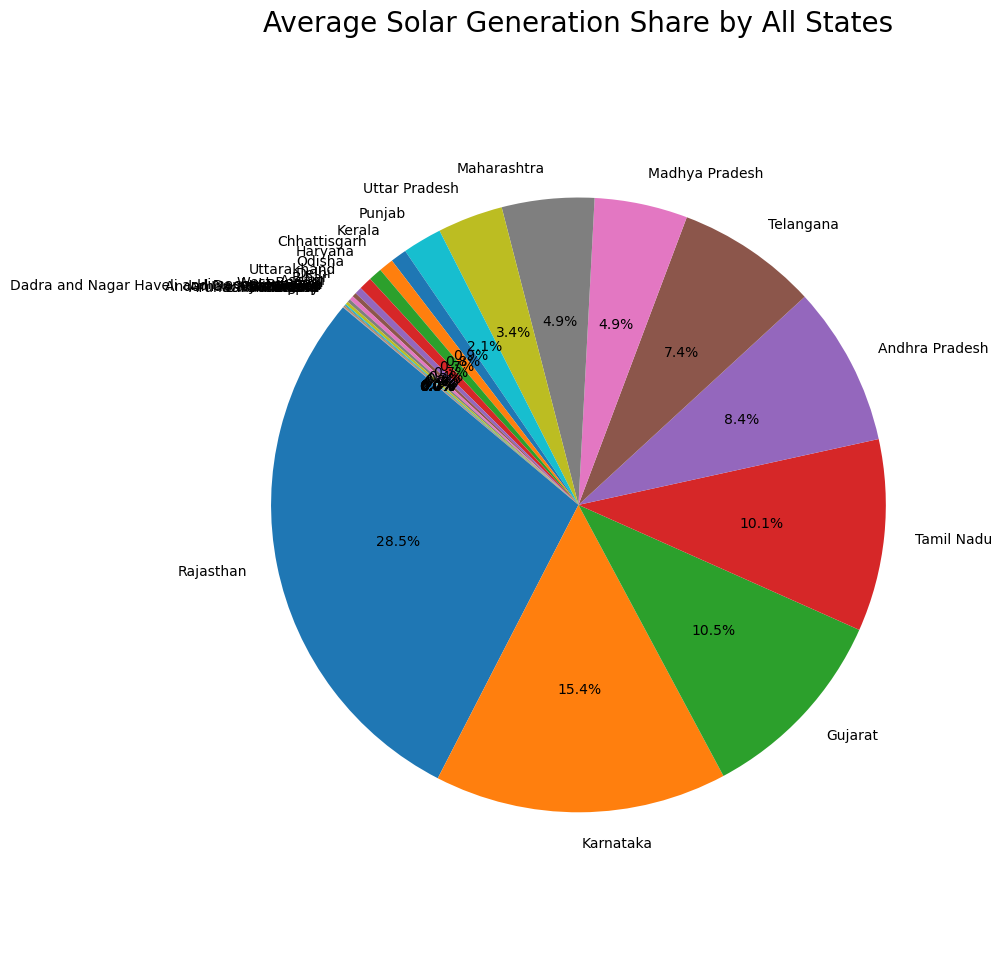

In [129]:
def plot_pie_all_states(data):
    avg_gen = data.groupby('State')['Solar Generation (GWh)'].mean().sort_values(ascending=False).reset_index()
    plt.figure(figsize=(10, 10))
    plt.pie(avg_gen['Solar Generation (GWh)'],labels=avg_gen['State'],autopct='%1.1f%%',startangle=140,textprops={'fontsize': 10})
    plt.title("Average Solar Generation Share by All States", fontsize=20)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

plot_pie_all_states(clean_data)

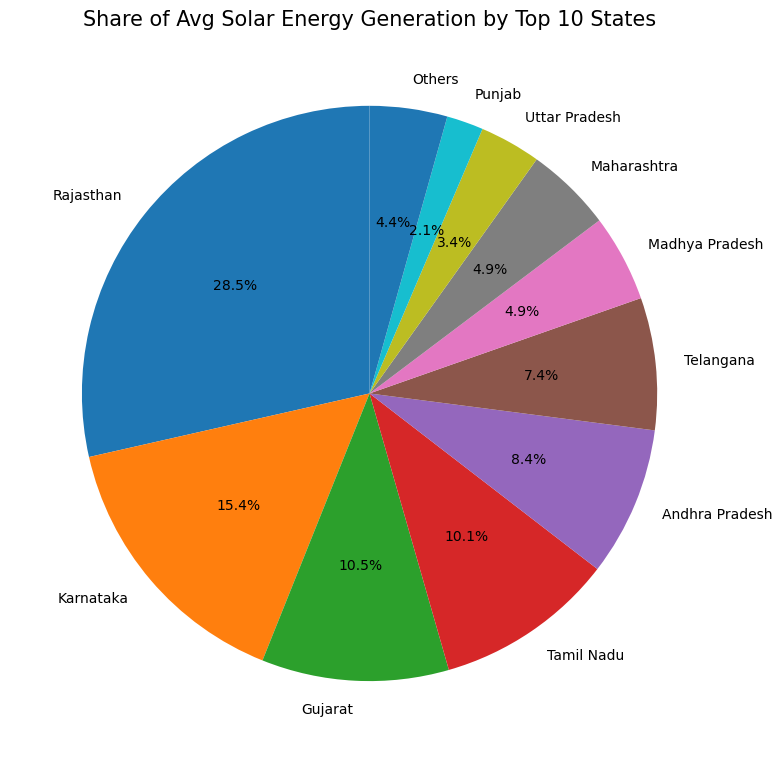

In [130]:
def plot_pie_top_10_simple(data):
    avg_gen = data.groupby('State')['Solar Generation (GWh)'].mean().sort_values(ascending=False)
    pie_data = avg_gen.head(10).copy()
    pie_data['Others'] = avg_gen.iloc[10:].sum()
    plt.figure(figsize=(8, 8))
    plt.pie(pie_data.values, labels=pie_data.index, autopct='%1.1f%%', startangle=90)
    plt.title("Share of Avg Solar Energy Generation by Top 10 States", fontsize=15)
    plt.tight_layout()
    plt.show()

plot_pie_top_10_simple(clean_data)

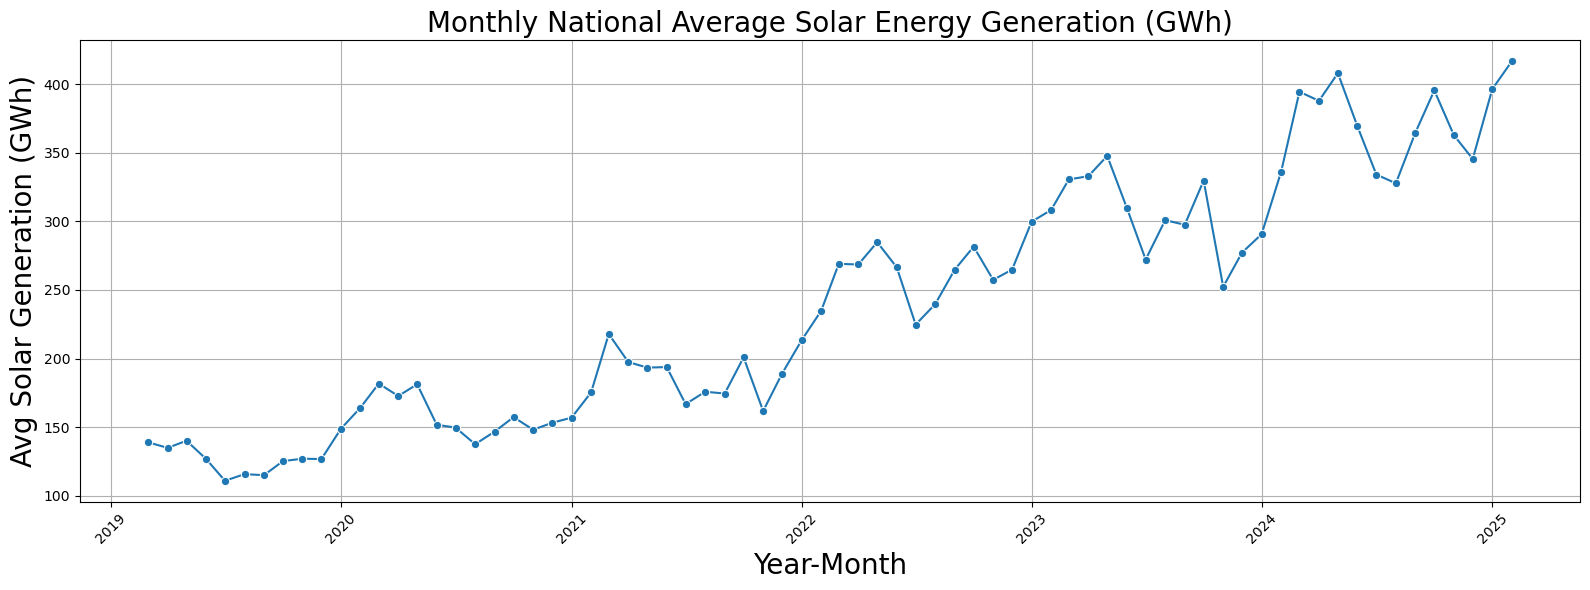

In [131]:
def plot_monthly_national_trend(data):
    monthly_avg = data.groupby('YearMonth')['Solar Generation (GWh)'].mean().reset_index()
    plt.figure(figsize=(16, 6))
    sns.lineplot(data=monthly_avg, x='YearMonth', y='Solar Generation (GWh)', marker='o')
    plt.title("Monthly National Average Solar Energy Generation (GWh)", fontsize = 20)
    plt.xlabel("Year-Month", fontsize = 20)
    plt.ylabel("Avg Solar Generation (GWh)", fontsize=20)
    plt.xticks(rotation=45, fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_monthly_national_trend(clean_data) 

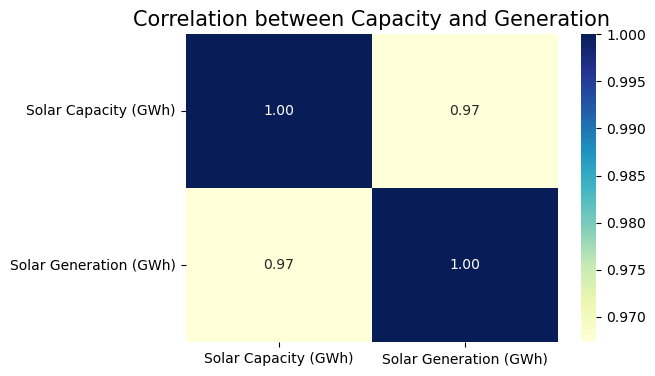

In [132]:
# Heatmap showing correlation between capacity and actual generation
def plot_heatmap(data):
    corr_data = data[['Solar Capacity (GWh)', 'Solar Generation (GWh)']]
    plt.figure(figsize=(6, 4))
    sns.heatmap(corr_data.corr(), annot=True, cmap='YlGnBu', fmt='.2f')
    plt.title("Correlation between Capacity and Generation", fontsize=15)
    plt.show()

plot_heatmap(clean_data)

In [133]:
gen_2020 = clean_data[clean_data['Year'] == 2020]['Solar Generation (GWh)']
gen_2024 = clean_data[clean_data['Year'] == 2024]['Solar Generation (GWh)']

t_stat, p_value = ttest_ind(gen_2020, gen_2024, equal_var=False)

print("T-statistic:", t_stat)
print("P-value:", p_value)

if p_value < 0.05:
    print("Statistically significant: Solar Generation has increased from 2020 to 2024.")
else:
    print("Not statistically significant: No strong evidence of change.")

T-statistic: -4.813080840093803
P-value: 2.006281456019869e-06
Statistically significant: Solar Generation has increased from 2020 to 2024.


In [134]:
X = clean_data[['State', 'Month', 'Year', 'Solar Capacity (GWh)']]
y = clean_data['Solar Generation (GWh)']

X = pd.get_dummies(X, columns=['State'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Linear Regression Evaluation
MAE : 48.42
MSE : 8633.19
RMSE: 92.91
R² Score (Test): 0.9714
R² Score (Train): 0.9634


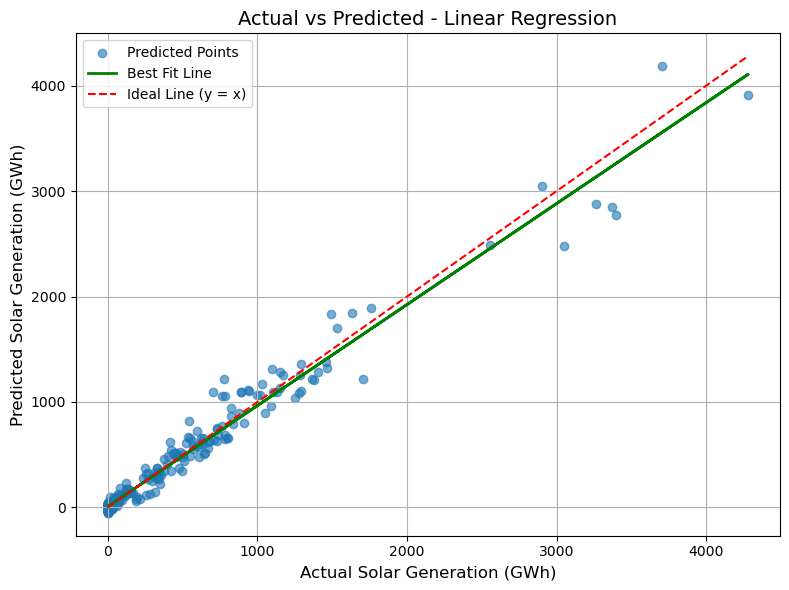

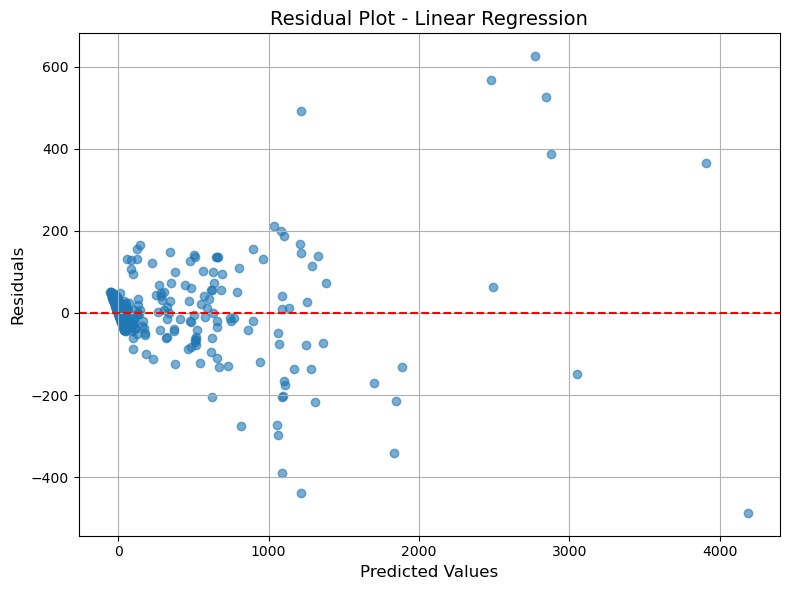

In [169]:
def run_linear_regression(X_train, X_test, y_train, y_test):

    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2_test = r2_score(y_test, y_pred)

    # Predict on train set for train R²
    y_train_pred = model.predict(X_train)
    r2_train = r2_score(y_train, y_train_pred)

    # Print evaluation results
    print("Linear Regression Evaluation")
    print("MAE :", round(mae, 2))
    print("MSE :", round(mse, 2))
    print("RMSE:", round(rmse, 2))
    print("R² Score (Test):", round(r2_test, 4))
    print("R² Score (Train):", round(r2_train, 4))

    # Plot Actual vs Predicted with Best Fit Line
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, label="Predicted Points")

    # Best fit line (actual vs predicted)
    y_test_reshaped = y_test.values.reshape(-1, 1)
    best_fit_model = LinearRegression()
    best_fit_model.fit(y_test_reshaped, y_pred)
    best_fit_line = best_fit_model.predict(y_test_reshaped)

    plt.plot(y_test, best_fit_line, color='green', linewidth=2, label="Best Fit Line")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Ideal Line (y = x)")
    plt.xlabel("Actual Solar Generation (GWh)", fontsize=12)
    plt.ylabel("Predicted Solar Generation (GWh)", fontsize=12)
    plt.title("Actual vs Predicted - Linear Regression", fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Residual Plot
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values", fontsize=12)
    plt.ylabel("Residuals", fontsize=12)
    plt.title("Residual Plot - Linear Regression", fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

run_linear_regression(X_train, X_test, y_train, y_test)


Random Forest Evaluation
MAE : 21.75
MSE : 3501.21
RMSE: 59.17
R² Score (Test): 0.9884
R² Score (Train): 0.9981


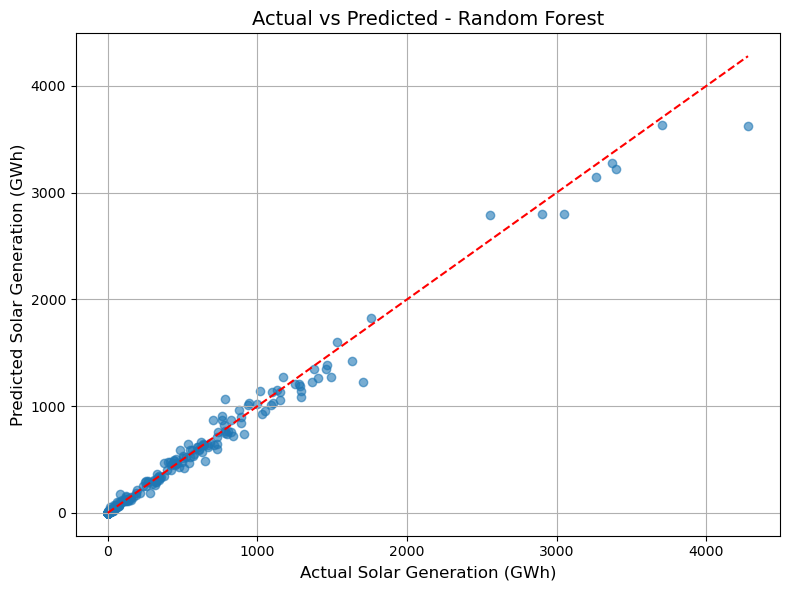

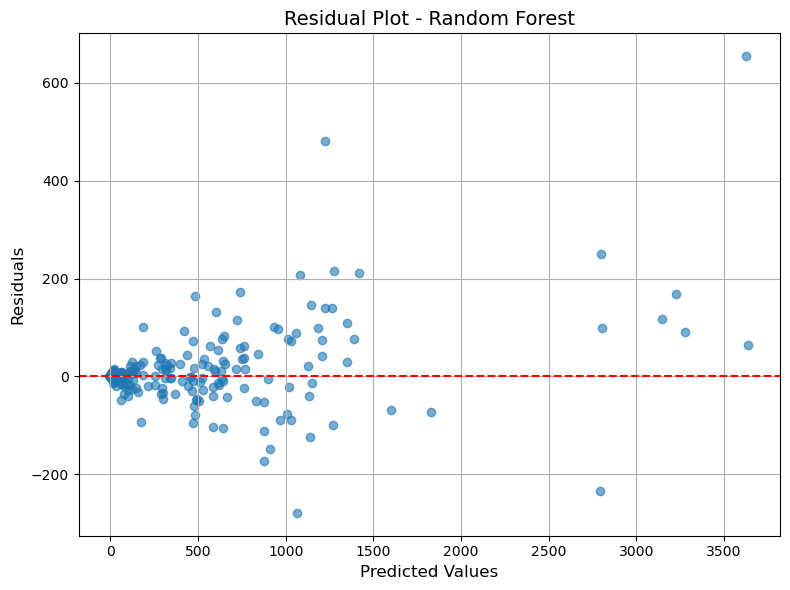

In [167]:
def run_random_forest(X_train, X_test, y_train, y_test):

    rf = RandomForestRegressor(random_state=42)

    # Fit the model
    rf.fit(X_train, y_train)

    # Predict on test set
    y_pred = rf.predict(X_test)

    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2_test = r2_score(y_test, y_pred)

    # Evaluate on train set
    y_train_pred = rf.predict(X_train)
    r2_train = r2_score(y_train, y_train_pred)

    # Print results
    print("Random Forest Evaluation")
    print("MAE :", round(mae, 2))
    print("MSE :", round(mse, 2))
    print("RMSE:", round(rmse, 2))
    print("R² Score (Test):", round(r2_test, 4))
    print("R² Score (Train):", round(r2_train, 4))

    # Plot Actual vs Predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Solar Generation (GWh)", fontsize=12)
    plt.ylabel("Predicted Solar Generation (GWh)", fontsize=12)
    plt.title("Actual vs Predicted - Random Forest", fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Residual plot
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values", fontsize=12)
    plt.ylabel("Residuals", fontsize=12)
    plt.title("Residual Plot - Random Forest", fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

run_random_forest(X_train, X_test, y_train, y_test)


Gradient Boosting Evaluation
MAE : 28.03
MSE : 5252.88
RMSE: 72.48
R² Score (Test): 0.9826
R² Score (Train): 0.9948


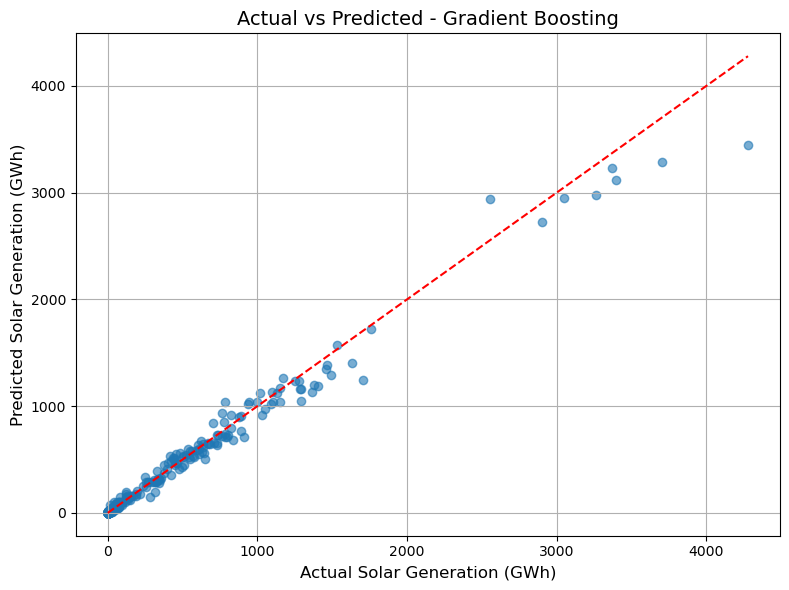

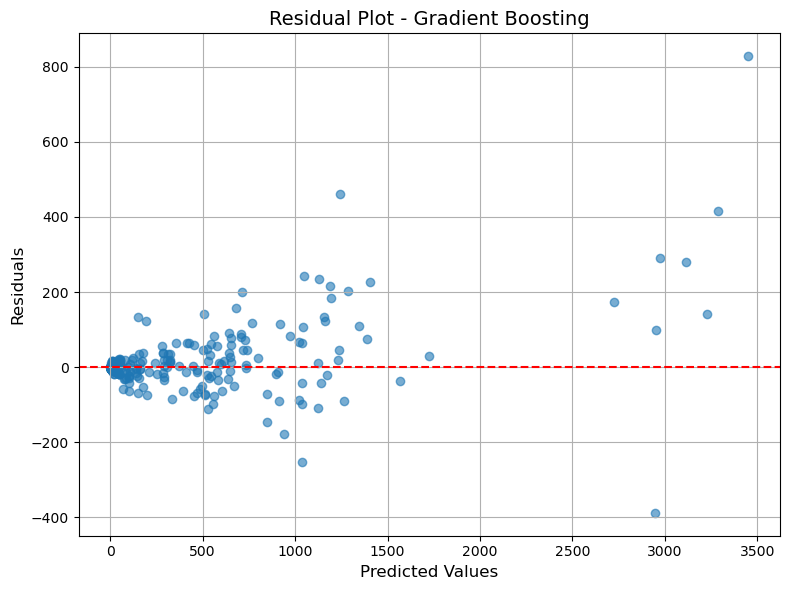

In [165]:
def run_gradient_boosting(X_train, X_test, y_train, y_test):

    gbr = GradientBoostingRegressor(random_state=42)

    # Fit to training data
    gbr.fit(X_train, y_train)

    # Predict on test set
    y_pred = gbr.predict(X_test)

    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2_test = r2_score(y_test, y_pred)

    # Predict on train set
    y_train_pred = gbr.predict(X_train)
    r2_train = r2_score(y_train, y_train_pred)

    # Print results
    print("\nGradient Boosting Evaluation")
    print("MAE :", round(mae, 2))
    print("MSE :", round(mse, 2))
    print("RMSE:", round(rmse, 2))
    print("R² Score (Test):", round(r2_test, 4))
    print("R² Score (Train):", round(r2_train, 4))

    # Plot Actual vs Predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Solar Generation (GWh)", fontsize=12)
    plt.ylabel("Predicted Solar Generation (GWh)", fontsize=12)
    plt.title("Actual vs Predicted - Gradient Boosting", fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot Residuals
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values", fontsize=12)
    plt.ylabel("Residuals", fontsize=12)
    plt.title("Residual Plot - Gradient Boosting", fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

run_gradient_boosting(X_train, X_test, y_train, y_test)